##Import Library

In [ ]:
!pip install --upgrade git+https://github.com/terrier-org/pyterrier.git
!pip install --upgrade PySastrawi
!pip install --upgrade transformers[torch]

  Cloning https://github.com/terrier-org/pyterrier.git to /tmp/pip-req-build-fvayr4io
  Running command git clone --filter=blob:none --quiet https://github.com/terrier-org/pyterrier.git /tmp/pip-req-build-fvayr4io
  Resolved https://github.com/terrier-org/pyterrier.git to commit a17f9b7ed1782010b4680457874f220b65fa2594
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!wget -O id_stops.txt https://snowballstem.org/algorithms/indonesian/stop.txt

--2024-05-14 06:56:22--  https://snowballstem.org/algorithms/indonesian/stop.txt
Resolving snowballstem.org (snowballstem.org)... 185.199.109.153, 185.199.110.153, 185.199.108.153, ...
Connecting to snowballstem.org (snowballstem.org)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1565 (1.5K) [text/plain]
Saving to: ‘id_stops.txt’

id_stops.txt        100%[===================>]   1.53K  --.-KB/s    in 0s      

2024-05-14 06:56:22 (19.7 MB/s) - ‘id_stops.txt’ saved [1565/1565]



In [ ]:
# import modules
import numpy as np
import random
import pyterrier as pt
import pandas as pd
import json
import re
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score,  precision_recall_fscore_support

from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader

from IPython.display import display

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from pyterrier.measures import *
from pyterrier.model import add_ranks

if not pt.started():
  pt.init(version = 'snapshot')

Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.1 has loaded Terrier 5.9 (built by jitpack on 2024-05-02 17:16) and terrier-helper 0.0.8



##Experiment

In [ ]:
# sometimes, query containing special chars like /,', or ? will produce errors
# https://github.com/terrier-org/pyterrier/issues/62
def remove_specials(text):
  text = text.replace("\n", " ")
  ret = ""
  for char in text:
    if char.isalnum() or char == " ":
      ret += char
    else:
      ret += " "
  return ret

In [ ]:
queries = pd.read_csv("query.csv", delimiter = "~")
collection = pd.read_csv("document.csv", delimiter = "~")
qrels = pd.read_csv("qrels edisi 2.csv", delimiter = "~")

# all ids as string, not integer
collection['docno'] = collection['docno'].astype(str)
queries['qid'] = queries['qid'].astype(str)
qrels['docno'] = qrels['docno'].astype(str)
qrels['qid'] = qrels['qid'].astype(str)

# save original text
collection['ori_text'] = collection['text']
queries['ori_query'] = queries['query']

In [ ]:
qid_set = queries['qid']
mask = collection['docno'].isin(qid_set)
collection = collection[mask]

In [ ]:
# remove special characters; sometimes indexing doesn't work without this step
collection['text'] = collection.apply(lambda x: remove_specials(x["text"]), axis = 1)
queries['query'] = queries.apply(lambda x: remove_specials(x["query"]), axis = 1)

# # create stemmer
# stemmerfactory = StemmerFactory()
# stemmer = stemmerfactory.create_stemmer()

# # create stopwordremover
# stopwordremoverfactory = StopWordRemoverFactory()
# stopwordremover = stopwordremoverfactory.create_stop_word_remover()

# # stemming
# collection['text'] = collection.apply(lambda x: stemmer.stem(x["text"]), axis = 1)
# queries['query'] = queries.apply(lambda x: stemmer.stem(x["query"]), axis = 1)

# # stop word removal
# collection['text'] = collection.apply(lambda x: stopwordremover.remove(x["text"]), axis = 1)
# queries['query'] = queries.apply(lambda x: stopwordremover.remove(x["query"]), axis = 1)

In [ ]:
collection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201 entries, 0 to 497
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   docno     201 non-null    object
 1   text      201 non-null    object
 2   ori_text  201 non-null    object
dtypes: object(3)
memory usage: 6.3+ KB


In [ ]:
qrels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   qid     321 non-null    object
 1   docno   321 non-null    object
 2   label   321 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 7.6+ KB


In [ ]:
collection

,docno,text,ori_text
0,1,Berdasarkan informasi yang diberikan perbuata...,"Berdasarkan informasi yang diberikan, perbuata..."
1,2,Perbuatan Terdakwa dilakukan dengan cara menus...,Perbuatan Terdakwa dilakukan dengan cara menus...
2,3,Berdasarkan informasi yang diberikan perbuata...,"Berdasarkan informasi yang diberikan, perbuata..."
3,4,Perbuatan terdakwa dilakukan dengan menggunaka...,Perbuatan terdakwa dilakukan dengan menggunaka...
5,6,Perbuatan terdakwa dilakukan secara bersama sa...,Perbuatan terdakwa dilakukan secara bersama-sa...
...,...,...,...
483,484,Perbuatan Terdakwa dilakukan dengan menyuruh m...,Perbuatan Terdakwa dilakukan dengan menyuruh m...
489,490,Perbuatan Terdakwa dilakukan dengan cara membu...,Perbuatan Terdakwa dilakukan dengan cara membu...
491,492,Perbuatan Terdakwa dilakukan dengan cara membu...,Perbuatan Terdakwa dilakukan dengan cara membu...
496,497,Para terdakwa melakukan perbuatan dengan mengg...,Para terdakwa melakukan perbuatan dengan mengg...


In [ ]:
queries

,qid,query,ori_query
0,26,Seseorang melakukan penambangan di kawasan hut...,Seseorang melakukan penambangan di kawasan hut...
1,27,Seseorang menggunakan dokumen palsu untuk peng...,Seseorang menggunakan dokumen palsu untuk peng...
2,28,Seseorang membangun rumah di kawasan hutan yan...,Seseorang membangun rumah di kawasan hutan yan...
3,117,Seorang pria menyetubuhi wanita tuna netra sec...,Seorang pria menyetubuhi wanita tuna netra sec...
4,116,Seorang pria yang secara sengaja masuk ke dala...,Seorang pria yang secara sengaja masuk ke dala...
...,...,...,...
198,404,Seseorang bersama rekannya menipu korban untuk...,Seseorang bersama rekannya menipu korban untuk...
199,396,Seseorang menggunakan surat BPKB palsu sebagai...,Seseorang menggunakan surat BPKB palsu sebagai...
200,401,Seorang laki laki melakukan penipuan dengan be...,Seorang laki-laki melakukan penipuan dengan be...
201,410,Setelah meminjam motor dari korban dan pergi k...,Setelah meminjam motor dari korban dan pergi k...


In [ ]:
qrels

,qid,docno,label
0,26,26,1
1,27,27,1
2,28,28,1
3,117,117,1
4,117,135,1
...,...,...,...
316,396,396,1
317,401,401,1
318,401,399,1
319,410,410,1


In [ ]:
!rm -rf ./caselaw_ir_index

pd_indexer = pt.DFIndexer("./caselaw_ir_index", \
                          type = pt.index.IndexingType(1), \
                          tokeniser = "UTFTokeniser", \
                          stemmer = None, \
                          stopwords = None, \
                          blocks = True)

index_ref = pd_indexer.index(collection["text"], collection)

In [ ]:
bm25_top = pt.BatchRetrieve(index_ref, wmodel = "BM25") % 10
bm25_top203 = pt.BatchRetrieve(index_ref, wmodel = "BM25") % 203
tfidf_top = pt.BatchRetrieve(index_ref, wmodel = "TF_IDF") % 10
pl2_top = pt.BatchRetrieve(index_ref, wmodel = "PL2") % 10

In [ ]:
res = bm25_top203.transform(queries)

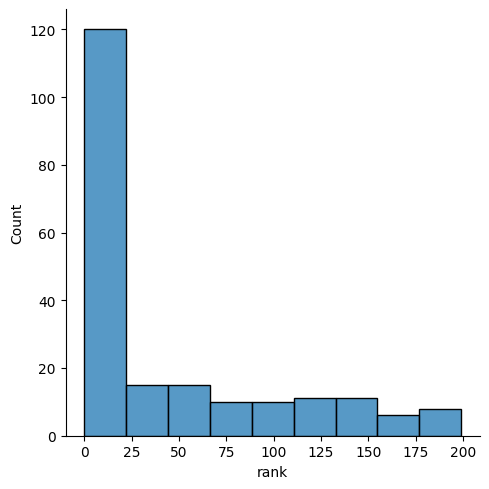

In [ ]:
sns.displot(res[res['docno'] == res['qid']]['rank'])

In [ ]:
ev = pt.Experiment(
    [bm25_top, tfidf_top, pl2_top, bm25_top203],
    queries,
    qrels,
    eval_metrics = ["recip_rank", "ndcg"]
)

In [ ]:
ev

,name,recip_rank,ndcg
0,"RankCutoff(BR(BM25), 10)",0.392405,0.365476
1,"RankCutoff(BR(TF_IDF), 10)",0.395238,0.373880
2,"RankCutoff(BR(PL2), 10)",0.391447,0.369205
3,"RankCutoff(BR(BM25), 203)",0.403140,0.470691


In [ ]:
number_of_cpus = 1

def add_label_column(run_df, qrels_df = None):
  """
  run_df => minimal [qid, docid, docno, rank, score]
  qrels_df => minimal [qid, docno, label]
  """
  assert qrels_df is not None, "qrels_df should not be empty"
  run_df = run_df.merge(qrels_df, on = ["qid", "docno"], how = "left")
  run_df["label"] = run_df["label"].fillna(0)
  run_df["label"] = run_df["label"].astype(int) # ensure labels are ints
  return run_df

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
  acc = accuracy_score(labels, predictions)
  return {
      'accuracy': acc,
      'f1': f1,
      'precision': precision,
      'recall': recall
  }

def train_bert(model, train_dataset, dev_dataset):
  if torch.cuda.is_available():
    device = torch.device(f"cuda")
    model.to(device)
  else:
    device = torch.device("cpu")
    model.to(device)

  training_args = TrainingArguments(
      output_dir='/content/data/results', \
      num_train_epochs = 4, \
      per_device_train_batch_size = 16, \
      per_device_eval_batch_size = 16, \
      warmup_steps = 100, \
      weight_decay = 0.01, \
      evaluation_strategy = "steps", \
      eval_steps = 16)

  # Inisialisasi Trainer
  trainer = Trainer(
      model = model,
      args = training_args,
      train_dataset = train_dataset,
      eval_dataset = dev_dataset,
      compute_metrics = compute_metrics)

  trainer.train()
  return model

def bert_score(model, dataset, batch_size = 16):
  if torch.cuda.is_available():
    device = torch.device(f"cuda")
    model.to(device)
  else:
    device = torch.device("cpu")
    model.to(device)

  preds = None
  nb_eval_steps = 0
  data_loader = DataLoader(dataset, \
                           batch_size = batch_size, \
                           num_workers = number_of_cpus, \
                           shuffle = False)
  for batch in data_loader:
    model.eval()
    with torch.no_grad():
      inputs = {'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'token_type_ids': batch['token_type_ids'].to(device)}
      outputs = model(**inputs)
      probs = torch.softmax(outputs.logits, dim = 1)
      nb_eval_steps += 1
      scores = probs[:, 1] # probability of relevant
      if preds is None:
        preds = scores.detach().cpu().numpy().flatten()
      else:
        batch_predictions = scores.detach().cpu().numpy().flatten()
        preds = np.append(preds, batch_predictions, axis = 0)
  return preds

class DFDataset(Dataset):
  def __init__(self, df, tokenizer, *args, split, get_doc_fn, tokenizer_batch=100):
    '''Initialize a Dataset object.
    Arguments:
        samples: A list of samples. Each sample should be a
        tuple with (query_id, doc_id, <label>), where label is optional
        tokenizer: A tokenizer object from Hugging Face's Tokenizer lib.
        (need to implement encode_batch())
        split: a name for this dataset
        get_doc_fn: a function that maps a row into the text of the document
        tokenizer_batch: How many samples to be tokenized at once by the tokenizer object.
    '''
    self.tokenizer = tokenizer
    tokenizer.padding_side = "right"
    print("Loading and tokenizing %s dataset of %d rows ..." % (split, len(df)))
    assert len(df) > 0
    self.labels_present = "label" in df.columns
    query_batch = []
    doc_batch = []
    sample_ids_batch = []
    labels_batch = []
    self.store = {}
    self.processed_samples = 0
    i = 0
    for indx, row in df.iterrows():
      query_batch.append(row["ori_query"])
      doc_batch.append(get_doc_fn(row))
      sample_ids_batch.append(row["qid"] + "_" + row["docno"])
      if self.labels_present:
        labels_batch.append(row["label"])
      else:
        labels_batch.append(-1) # no labels; for testing, not for training
      if len(query_batch) == tokenizer_batch or i == len(df) - 1:
        self._tokenize_and_dump_batch(doc_batch, query_batch, labels_batch, sample_ids_batch)
        query_batch = []
        doc_batch = []
        sample_ids_batch = []
        labels_batch = []
      i += 1

  def _tokenize_and_dump_batch(self, doc_batch, query_batch, labels_batch,
                               sample_ids_batch):
    '''tokenizes and dumps the samples in the current batch
    It also store the positions from the current file into the samples_offset_dict.
    '''
    # Use the tokenizer object
    #batch_tokens = self.tokenizer.batch_encode_plus(list(zip(query_batch, doc_batch)), max_length=512, pad_to_max_length=True)
    batch_tokens = self.tokenizer.batch_encode_plus(list(zip(query_batch, doc_batch)), max_length=512, padding='max_length', truncation=True)
    for idx, (sample_id, tokens) in enumerate(zip(sample_ids_batch, batch_tokens['input_ids'])):
      assert len(tokens) == 512
      # BERT supports up to 512 tokens. batch_encode_plus will enforce this for us.
      # the original implementation had code to truncate long documents with [SEP]
      # or pad short documents with [0]
      segment_ids = batch_tokens['token_type_ids'][idx]
      attention_mask = batch_tokens['attention_mask'][idx]
      self._store(sample_id, tokens, attention_mask, segment_ids, labels_batch[idx])
      self.processed_samples += 1

  def _store(self, sample_id, token_ids, attention_mask, segment_ids, label):
    self.store[self.processed_samples] = (sample_id, token_ids, attention_mask, segment_ids, label)

  def __getitem__(self, idx):
    _, input_ids, attention_mask, token_type_ids, label = self.store[idx]
    out_dict = {'input_ids': torch.tensor(input_ids, dtype = torch.long),
                'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype = torch.long),
                'labels': torch.tensor([label], dtype = torch.long)}
    if not self.labels_present:
      del out_dict['labels']
    return out_dict

  def __len__(self):
    return len(self.store)

class BERTPipeline(pt.Estimator):

  def __init__(self, *args,
    get_doc_fn = lambda row: row["ori_text"],
    max_train_rank = None,
    max_valid_rank = None,
    cache_threshold = None,
    **kwargs):
    super().__init__(*args, **kwargs)
    self.tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')
    self.model = BertForSequenceClassification.from_pretrained("indolem/indobert-base-uncased", num_labels = 2)
    self.max_train_rank = max_train_rank
    self.max_valid_rank = max_valid_rank
    self.get_doc_fn = get_doc_fn
    self.test_batch_size = 16
    self.cache_threshold = cache_threshold
    self.cache_dir = None

  def make_dataset(self, res, *args, **kwargs):
    return DFDataset(res, *args, **kwargs)

  def fit(self, tr, qrels_tr, va, qrels_va):
    tr = add_label_column(tr, qrels_tr)
    va = add_label_column(va, qrels_va)

    #print(tr.head(20))

    if self.max_train_rank is not None:
      tr = tr[tr["rank"] < self.max_train_rank]
    if self.max_valid_rank is not None:
      va = va[va["rank"] < self.max_valid_rank]

    tr_dataset = self.make_dataset(tr, self.tokenizer, split = "train", get_doc_fn = self.get_doc_fn)
    assert len(tr_dataset) > 0
    va_dataset = self.make_dataset(va, self.tokenizer, split = "valid", get_doc_fn = self.get_doc_fn)
    assert len(va_dataset) > 0
    self.model = train_bert(self.model, tr_dataset, va_dataset)
    return self

  def transform(self, te):
    te_dataset = DFDataset(te, self.tokenizer, split = "test", get_doc_fn = self.get_doc_fn)
    scores = bert_score(self.model, te_dataset, batch_size = self.test_batch_size)
    assert len(scores) == len(te), "Expected %d scores, but got %d" % (len(te), len(scores))
    te["score"] = scores
    return add_ranks(te)

  def load(self, filename):
    self.model.load_state_dict(torch.load(filename), strict=False)

  def save(self, filename):
    state = self.model.state_dict(keep_vars=True)
    for key in list(state):
      if state[key].requires_grad:
        state[key] = state[key].data
      else:
        del state[key]
    torch.save(state, filename)

In [ ]:
bert_tfidf_reranker = tfidf_top >> pt.text.get_text(index_ref, "ori_text") >> BERTPipeline()
bert_bm25_reranker = bm25_top >> pt.text.get_text(index_ref, "ori_text") >> BERTPipeline()

# however, when we call .fit() from this pipeline, topics df only
# contains at minimum [qid, query].
bert_tfidf_reranker.fit(queries, qrels, queries, qrels)
bert_bm25_reranker.fit(queries, qrels, queries, qrels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading and tokenizing train dataset of 2070 rows ...
Loading and tokenizing valid dataset of 2070 rows ...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
16,No log,0.260710,0.926087,0.000000,0.000000,0.000000
32,No log,0.287074,0.926087,0.000000,0.000000,0.000000
48,No log,0.261003,0.926087,0.000000,0.000000,0.000000
64,No log,0.259848,0.926087,0.000000,0.000000,0.000000
80,No log,0.321427,0.926087,0.000000,0.000000,0.000000
96,No log,0.264526,0.926087,0.000000,0.000000,0.000000
112,No log,0.264834,0.926087,0.000000,0.000000,0.000000
128,No log,0.276666,0.926087,0.000000,0.000000,0.000000
144,No log,0.247546,0.926087,0.000000,0.000000,0.000000
160,No log,0.305098,0.926087,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

In [ ]:
bert_reranker.transform(queries)

Loading and tokenizing test dataset of 2054 rows ...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,qid,docid,docno,score,query,ori_query,ori_text,rank
0,26,10,26,0.577958,tambang kawasan hutan produksi milik izin rusa...,Seseorang melakukan penambangan di kawasan hut...,"Berdasarkan informasi yang diberikan, perbuata...",0
1,26,27,63,0.015745,tambang kawasan hutan produksi milik izin rusa...,Seseorang melakukan penambangan di kawasan hut...,Perbuatan terdakwa dilakukan dengan cara meram...,2
2,26,97,246,0.012566,tambang kawasan hutan produksi milik izin rusa...,Seseorang melakukan penambangan di kawasan hut...,"Berdasarkan informasi yang tersedia, terdakwa ...",7
3,26,180,454,0.013994,tambang kawasan hutan produksi milik izin rusa...,Seseorang melakukan penambangan di kawasan hut...,"Berdasarkan informasi yang diberikan, perbuata...",4
4,26,11,27,0.013422,tambang kawasan hutan produksi milik izin rusa...,Seseorang melakukan penambangan di kawasan hut...,"Berdasarkan informasi yang diberikan, terdakwa...",6
...,...,...,...,...,...,...,...,...
13056,406,29,68,0.012532,bantu kenal montir jual mobil hasil tipu komis...,Seseorang membantu kenalannya yang seorang mon...,Terdakwa melakukan perbuatan dengan cara melak...,2
13057,406,37,85,0.010819,bantu kenal montir jual mobil hasil tipu komis...,Seseorang membantu kenalannya yang seorang mon...,Perbuatan Terdakwa dilakukan dengan cara melar...,9
13058,406,11,27,0.011571,bantu kenal montir jual mobil hasil tipu komis...,Seseorang membantu kenalannya yang seorang mon...,"Berdasarkan informasi yang diberikan, terdakwa...",6
13059,406,80,205,0.011633,bantu kenal montir jual mobil hasil tipu komis...,Seseorang membantu kenalannya yang seorang mon...,Perbuatan Terdakwa dilakukan dengan menggunaka...,5


In [ ]:
pt.Experiment(
    [bm25_top, bert_tfidf_reranker, bert_bm25_reranker],
    queries,
    qrels,
    eval_metrics = ["recip_rank", "ndcg"]
)

Loading and tokenizing test dataset of 2054 rows ...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,name,recip_rank,ndcg
0,"RankCutoff(BR(BM25), 10)",0.449746,0.433632
1,"Compose(Compose(RankCutoff(BR(BM25), 10), pt.a...",0.535462,0.494668
